Epoch 1/80  Train Loss=1430.1590  Val Loss=1302.0618
Epoch 2/80  Train Loss=647.2413  Val Loss=318.1027
Epoch 3/80  Train Loss=159.0494  Val Loss=212.5835
Epoch 4/80  Train Loss=85.7085  Val Loss=227.9966
Epoch 5/80  Train Loss=71.2580  Val Loss=181.4881
Epoch 6/80  Train Loss=60.3830  Val Loss=183.5792
Epoch 7/80  Train Loss=56.4580  Val Loss=170.6553
Epoch 8/80  Train Loss=53.2142  Val Loss=162.4274
Epoch 9/80  Train Loss=57.9636  Val Loss=162.1695
Epoch 10/80  Train Loss=51.0744  Val Loss=156.8091
Epoch 11/80  Train Loss=50.7848  Val Loss=156.6168
Epoch 12/80  Train Loss=50.5689  Val Loss=163.1919
Epoch 13/80  Train Loss=45.6807  Val Loss=158.4905
Epoch 14/80  Train Loss=48.2348  Val Loss=152.2009
Epoch 15/80  Train Loss=43.8488  Val Loss=162.6543
Epoch 16/80  Train Loss=46.8692  Val Loss=154.2504
Epoch 17/80  Train Loss=44.5293  Val Loss=157.2083
Epoch 18/80  Train Loss=44.7970  Val Loss=151.7417
Epoch 19/80  Train Loss=46.4532  Val Loss=159.9799
Epoch 20/80  Train Loss=43.5251  Va

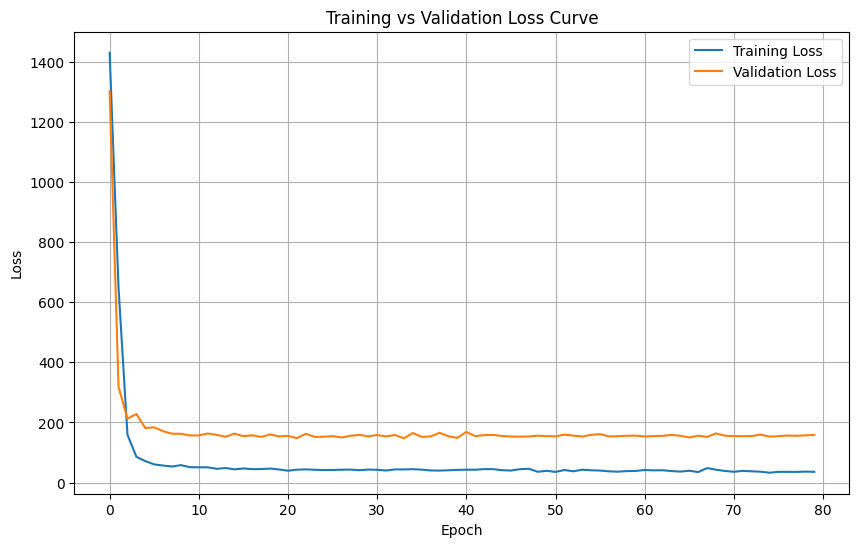

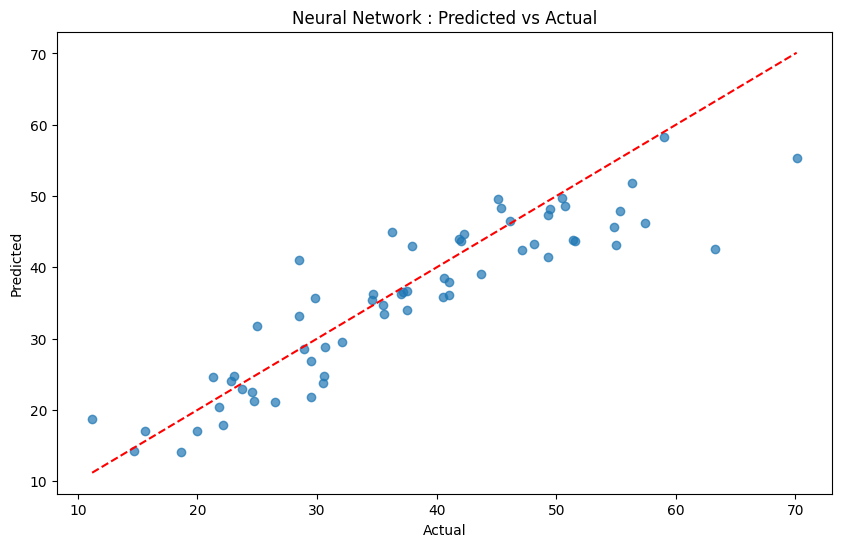

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ======================================================
# 1. Load Data
# ======================================================
X_train = pd.read_csv("X_train_corr_filtered.csv").values
y_train = pd.read_csv("y_train.csv").iloc[:, 0].values

X_test = pd.read_csv("X_test_corr_filtered.csv").values
y_test = pd.read_csv("y_test.csv").iloc[:, 0].values

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# ======================================================
# 2. Neural Network Architecture (BEST PARAMS)
# ======================================================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 180)
        self.fc2 = nn.Linear(180, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.08395103944399458)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ======================================================
# 3. Initialize Model
# ======================================================
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003649463423057799)

batch_size = 16
epochs = 80

# ======================================================
# 4. Create Validation Split for plotting (15%)
# ======================================================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, shuffle=True
)

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

# ======================================================
# 5. Training Loop (with tracking Loss)
# ======================================================
model.train()
for epoch in range(epochs):

    batch_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    # ===== Validation Loss =====
    model.eval()
    with torch.no_grad():
        val_batch_losses = []
        for xb, yb in val_loader:
            v_pred = model(xb)
            v_loss = criterion(v_pred, yb)
            val_batch_losses.append(v_loss.item())

        val_loss = np.mean(val_batch_losses)
        val_losses.append(val_loss)

    model.train()

    print(f"Epoch {epoch+1}/{epochs}  Train Loss={train_loss:.4f}  Val Loss={val_loss:.4f}")

# ======================================================
# 6. Predict on TEST
# ======================================================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()

# ======================================================
# 7. Evaluation
# ======================================================
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n===== FINAL PyTorch NN Evaluation  =====")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


# Training vs Validation Loss Curve

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# 9. Plot Predicted vs Actual
# ======================================================
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)

min_v, max_v = min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))
plt.plot([min_v, max_v], [min_v, max_v], "r--")

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Neural Network : Predicted vs Actual")
plt.show()
